## EEE4114F: Computer assignment 3 ##

This assignment explores the process of digital filtering on audio
signals. If possible, you should use a computer with a sound card and
either speakers or earphones. The discussion is based around Python with `numpy`, but
with minor changes you should be able to translate it into the
programming language of your choice.

You will need a clip of single-channel digitised sound, sampled at a
known rate. An instance of Handel’s Messiah sampled at 8192 Hz is provided
with this assignment in the file "handel8192.txt".  It has one text-valued
real sample per line (which is an awful way of distributing binary data) and can be loaded using the command

> `y = np.loadtxt('handel8192.txt')`

if the file is on your path.  The data is loaded into the variable `y`.  You can play on the sound device using

> `import sounddevice as sd`
> `sd.play(y,8192)`

if you have successfully installed `python-sounddevice`.

In [3]:
import numpy as np
import sounddevice as sd
import wave

fs = 8192  # sampling frequency for clip
y = np.loadtxt('../data/handel8192.txt')
#sd.play(y,fs)

In [17]:

def wav_to_float(wav_file, num_samples):
    """
    Convert WAV file to 32-bit float raw data and truncate it to the given number of samples.
    
    Args:
        wav_file (str): Path to the WAV file.
        num_samples (int): Number of samples to keep.
        
    Returns:
        np.ndarray: Truncated audio data as a numpy array of 32-bit float values.
    """
    with wave.open(wav_file, 'r') as wav:
        # Get WAV file parameters
        num_channels = wav.getnchannels()
        sample_width = wav.getsampwidth()
        sample_rate = wav.getframerate()
        num_frames = wav.getnframes()
        
        # Read WAV file data
        wav_data = wav.readframes(num_frames)
        
        # Convert bytes to a numpy array
        np_data = np.frombuffer(wav_data, dtype=np.int16)
        
        # Convert numpy array to 32-bit float
        float_data = np_data.astype(np.float32) / (2 ** 15)
        
        # Truncate the data to the given number of samples
        truncated_data = float_data #[:num_samples]
        
        # Reshape the array based on the number of channels
        if num_channels == 1:
            print("1 channel")
            audio_data = truncated_data
        else:
            audio_data = truncated_data.reshape(-1, num_channels)
        
        return audio_data, sample_rate

In [41]:
audio_data, sample_rate = wav_to_float('../data/audio_files/harvard.wav', 0)
print(sample_rate)

44100


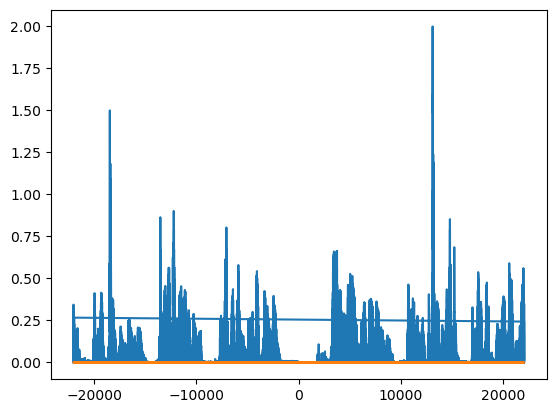

In [34]:
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = len(audio_data)

yf = fft(audio_data)
xf = fftfreq(N, 1 / sample_rate)

plt.plot(xf, np.abs(yf))
plt.show()

In [35]:
sd.play(audio_data,sample_rate)

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


length: 809508


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


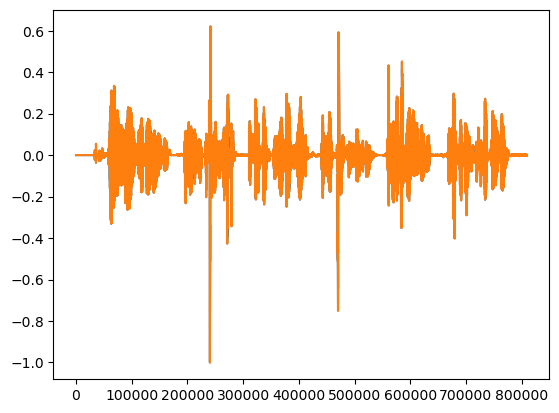

In [36]:
print("length: "+str(len(audio_data)))

import matplotlib.pyplot as plt

plt.plot(audio_data)

length: 809508


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


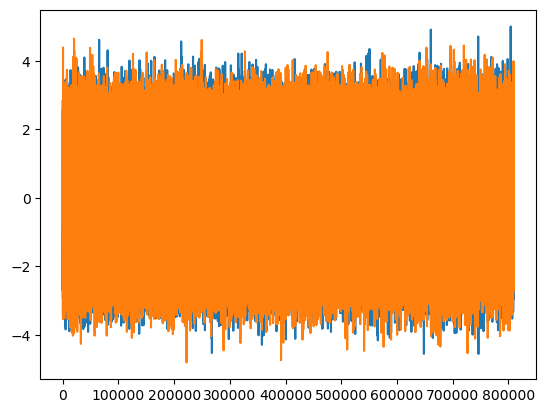

In [37]:
gaussian_noise = np.random.normal(0, 1, audio_data.shape)
print("length: "+str(len(gaussian_noise)))
plt.plot(gaussian_noise)


In [38]:
sd.play(gaussian_noise,sample_rate)

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


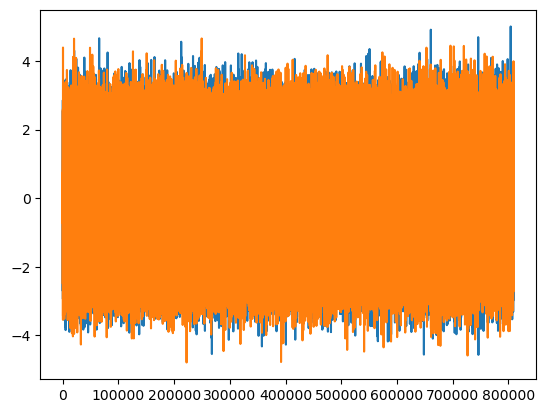

In [39]:
y_noisy = audio_data+gaussian_noise
plt.plot(y_noisy)

In [40]:
sd.play(y_noisy,sample_rate)

# Feel free to use other sources if you like — it’s instructive to find
out how to load data into different software packages and libraries.

You will also need a filter design tool. These often cost money. If
your PC has the MATLAB signal processing toolbox installed, there’s a
GUI-based design tool called `fdatool`. Similar functionality is in the Python GUI tool `pyFDA` (https://pypi.org/project/pyfda).  The `scipy` package has some relevant functionality in `scipy.signal.firls`, for example. Design packages can often export filter coefficients to C, but you can also just cut and paste them into a file as needed.

1.  **Simple highpass filter from lowpass prototype:** Some filter
    design packages only let you design a lowpass filter as a prototype.
    Even if your package lets you design a highpass filter directly, for
    this task you should only use the lowpass design functionality.

    Suppose the frequency response of a lowpass filter is
    $H_{lp}(e^{j \omega})$. If this is a reasonable filter with cutoff
    $\omega_0$ then it should have unity gain when
    $|\omega| \leq \omega_0$ and zero gain otherwise. The filter with
    response $$H_{hp}(e^{j \omega}) = 1 - H_{lp}(e^{j \omega})$$ should
    then be a highpass filter with approximate response
    $$H_{hp}(e^{j \omega}) \approx \begin{cases} 0 \quad & |\omega|<\omega_0 \\ 1 \quad & \text{otherwise}. \end{cases}$$
    The impulse responses then satisfy
    $h_{hp}[n] = \delta[n] - h_{lp}[n]$.

    Design a lowpass filter with a cutoff of $\omega_0 = \pi/2$. This
    will give you an impulse response $h_{lp}[n]$ with values in
    `impresplp` that implements the filter via convolution. The
    corresponding `impresphp` that implements a highpass filter, which
    here will have a cutoff $\omega_0 = \pi/2$, can be obtained from
    `impresplp` using the formula above.

In [6]:
impresplp = []

2.  **Highpass filter from lowpass prototype via frequency shifting:**

    Suppose the frequency response of a lowpass filter is
    $H_{lp}(e^{j \omega})$. The frequency shift property states that
    $$e^{j \omega_0 n} x[n] \quad \Longleftrightarrow \quad H(e^{j(\omega-\omega_0)}),$$
    which for $\omega_0 = \pi$ means that
    $$e^{j \pi n} x[n] = (-1)^n x[n] \quad \Longleftrightarrow \quad H(e^{j(\omega-\pi)}).$$
    If we define the highpass filter
    $H_{hp}(e^{j \omega}) = H_{lp}(e^{j (\omega-\pi)})$ using frequency
    shifting then the corresponding highpass filter impulse response is
    $h_{hp}[n] = (-1)^n h_{lp}[n]$. For $h_{lp}[n]$ real the impulse
    response $h_{hp}[n]$ will still be real, and its values can be
    obtained from $h_{lp}[n]$ by simply changing the sign of every
    alternate value.

    Design a lowpass filter with a cutoff of $\omega_0 = \pi/2$. This
    will give you an impulse response $h_{lp}[n]$ with values in
    `impresplp` that implements the filter via convolution. The
    corresponding `impresphp` that implements a highpass filter, which
    here will have a cutoff $\omega_0 = \pi - \pi/2 = \pi/2$, can be
    obtained from `impresphp` by switching signs as explained above.

In [7]:
impresphp = []

3.  **Filter out narrow-band interference:** Create a corrupted signal
    by adding a sinusoid with frequency $\omega_0 = \pi/4$:

    > `yc = y + a0*np.sin(np.pi/4*np.arange(len(y)))`

    where say `a0 = 1` is some scale factor. Since the sampling frequency 8192
    Hz corresponds to $\omega = 2 \pi$, the above sinusoid with angular
    frequency $\omega_0 =\pi/4$ corresponds to a 1024 Hz interference
    component. You can listen to the sample:

    > `sd.play(yc,8192)`

    Use a filter design tool to find the impulse response `impresp` of a
    bandstop filter for nulling this interference. The filtered output
    signal can be calculated using

    > `ycf = np.convolve(yc,impresp)`

    which you can also listen to using the `sd.play` command. Note that
    while this eliminates the interfering tone, it also nulls the signal
    in the stop band of the filter.

    The signals `ycf` and `yc` above are *not* generally the same size — what’s
    going on?

In [15]:
# Create corrupted signal
w0 = np.pi/4
a0 = 1
yc = y + a0*np.sin(np.pi/4*np.arange(len(y)))

# Find impresp below
impresp = np.array((0,0,0,1,0,0,0)) # simple delay for now

# Generate output
ycf = np.convolve(yc,impresp)
sd.play(ycf,fs)

4.  **Filter out 200 Hz interference:** Create a signal corrupted by 200
    Hz interference, and make a highpass filter to remove it. This turns
    out to be a very long FIR filter, or a fairly short IIR filter. You
    may wish to explore both options. However, the IIR filter does not
    have linear phase.

    **Note:** using a FIR filter to remove 50 Hz interference is even
    harder (try it!). The reason 200 Hz was chosen in this experiment is
    because 50 Hz is too low for our ears to hear (or for the soundcard
    to play).

5.  **Downsampling:** The sound clip is sampled at 8192 samples per
    second. To reduce the sampling rate by a factor of 2 (to give a 4192
    Hz sample), you need to filter out all content above $4192/2 = 2048$
    Hz and then discard every second sample. This cutoff frequency
    corresponds to $\omega = \pi/2$ in the angular frequency domain.

    Use a filter design tool to find the impulse response `impresp` of a
    lowpass filter with the required cutoff of $\omega = \pi/2$. The
    filtered output signal can be found using

    > `y_lp = np.convolve(y,impresp,'same');`

    and the resulting decimated signal is

    > `yd2 = y_lp[::2]`

    The signal `yd2` is now effectively sampled at 4192 Hz. You can
    compare the sound of the properly downsampled version of the signal
    to the aliased version:

    > `sd.play(yd2,4192)` versus `sd.play(y[::2],4192)`

    Applying *the same* lowpass filter as before to the downsampled data
    using

    > `y_lp = np.convolve(yd2,impresp)`

    eliminates all frequencies below 1024 Hz (because the actual cutoff
    frequency of the filter depends on the sampling rate!), so we can
    decimate again by a factor of two without aliasing:

    > `yd4 = y_lp[::2]`

    This signal is effectively sampled at 2048 Hz. You can again compare
    the sound of good and bad downsampling:

    > `sd.play(yd4,2048)` versus `sd.play(y[::4],2048)`.

    Create plots of the frequency response magnitude and phase of the appropriate lowpass filter.

6.  **Upsampling:** The sound clip is sampled at 8192 Hz. To convert it
    to a 16384 Hz signal which can be played using

    > `sd.play(xxx,16384)`

    it needs to be upsampled by a factor of 2. Create the expanded
    signal `yexp` by inserting zeros into the signal between the samples

    > `yexp = np.zeros((2*len(y),));  yexp[0::2] = y`

    and lowpass filter it with an appropriate impulse response `impresp`
    to eliminate the replicas:

    > `yu2 = np.convolve(yexp,impresp);`

    You can listen to the upsampled signal `yu2` (while it has more
    samples it contains no more information than the original 8192 Hz
    sample), and you can hear the effect of the replicas by listening to
    the intermediate expanded signal `yexp`.

In [5]:
x = [1,2,3,4,5]
y = np.zeros((2*len(x),))

print(x)
print(y)

y[0::2]=x
print(y)

[1, 2, 3, 4, 5]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 2. 0. 3. 0. 4. 0. 5. 0.]


7.  **Hardware implementation:** (optional) Implement a simple filter on
    a microprocessor like the STM32F. In the simplest instance you could
    configure an ADC to raise an interrupt when a new input sample is
    available. The ISR would then take this new value along with a ring
    buffer of previous stored inputs, calculate the convolution result
    for the current time instant by weighting the samples with the
    impulse response values and summing, write the result to a DAC, and
    update the ring buffer with the latest sample value.

    As described this would be a naive time-domain implementation of the
    convolution operation, which is often all that is required.